In [100]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

from datetime import datetime
from geopy.distance import geodesic
from geopy import distance
import geopandas as gpd
from shapely.geometry import box, Point


import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import  plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MiniBatchKMeans
from scipy import stats
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import accuracy_score
from scipy.stats import kstest, gamma, probplot

# Random state 
random_state = 42
np.random.seed(random_state)

# Palette color for plots
yellow ='#dfdc7bff'
grey = '#50566dff'
white = '#d9cebfff'
orange = '#e5b97bff'


# **1. Data Preprocessing**

In [101]:
taxi_trip = pd.read_csv('../data/raw/nyc-yellow-taxi-trip-2016.csv',
                parse_dates=['pickup_datetime','dropoff_datetime'])

display(taxi_trip.head(3))

print("Shape:", taxi_trip.shape)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


Shape: (1458644, 11)


Let's check the dataset information, and see if there is any missing value or duplicated rows:

In [102]:
print(taxi_trip.info())
print("\n Duplicated rows:", taxi_trip.duplicated().sum())
print("\n Missing values:", taxi_trip.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB
None

 Duplicated rows: 0

 Missing values: 0


There are no missing values or duplicated rows. The only feature that we need to change is `store_and_fwd_flag`, which is a categorical feature $\{N, Y\}$. We will change it to a boolean mapping `Y` to `True`  and `N` to `False`: 

In [103]:
# Map store_and_fwd_flag to True and False 
taxi_trip['store_and_fwd_flag'] = taxi_trip['store_and_fwd_flag'].map({'N': False, 'Y': True})

Let's verify if the target feature `trip_duration` is correct by calculating the time difference between `dropoff_datetime` and `pickup_datetime` in seconds :

In [104]:
trip_duration = (taxi_trip['dropoff_datetime'] - taxi_trip['pickup_datetime']).dt.seconds

is_diff = (trip_duration != taxi_trip['trip_duration'])
print( 'Number of incorrect values in trip_duration:',is_diff.sum())

display(taxi_trip[is_diff])

Number of incorrect values in trip_duration: 4


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,False,1939736
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,False,2049578
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,False,2227612
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,False,3526282


It appears that there are four extreme values in the target feature `trip_duration` that don't make sense. We can correct then by substituting the values of the actual trip duration in seconds that was calculated. Let's simple substitute for the correct column that we calculate:

In [105]:
taxi_trip['trip_duration'] = trip_duration

# Let's check again

is_diff = (trip_duration != taxi_trip['trip_duration'])
print( 'Number of incorrect values in trip_duration:',is_diff.sum())

Number of incorrect values in trip_duration: 0


# **2. Outliers**

Before splitting the dataset, we need to search for outliers. We will use geospatial visualization to identify outliers in the pickup and dropoff locations and the interquartile range (IQR) with box plot to identify outliers in the `trip_duration`. Let's first consider all features with dtypes  `float64`, `int64` in the dataset:

In [106]:
#taxi_trip  = pd.read_csv('../data/interim/nyc-taxi-trip-2016-intermediate.csv', parse_dates=['pickup_datetime'])
taxi_trip_filtered = taxi_trip.select_dtypes(include=['float64', 'int64'])
display(taxi_trip_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vendor_id          1458644 non-null  int64  
 1   passenger_count    1458644 non-null  int64  
 2   pickup_longitude   1458644 non-null  float64
 3   pickup_latitude    1458644 non-null  float64
 4   dropoff_longitude  1458644 non-null  float64
 5   dropoff_latitude   1458644 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 66.8 MB


None

When looking for outlier in the dataset, we should focus on numerical features. We can see that the features `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `trip_duration`, are good candidates for outlier analysis.

## 2.1. Location Features

There are two locations, pickup and dropoff location. To find out if there is any outliers, we can analyze the features `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`. 

In [107]:
# Copy the original dataset
trip_outliers = taxi_trip.copy()

# can be useful to separate the features
pickup_dropoff_features = [ 'pickup_longitude', 'pickup_latitude', 
                            'dropoff_longitude', 'dropoff_latitude' ]

pickup_long = trip_outliers['pickup_longitude']
pickup_lat = trip_outliers['pickup_latitude']
dropoff_long = trip_outliers['dropoff_longitude']
dropoff_lat = trip_outliers['dropoff_latitude']

# Summary statistics
display(    trip_outliers.groupby('passenger_count')[pickup_dropoff_features[:2]]
            .agg(['min', 'mean', 'max']))

display(    trip_outliers.groupby('passenger_count')[pickup_dropoff_features[2:]]
            .agg(['min', 'mean', 'max']))

pickup_longitude                       pickup_latitude  \
                             min       mean        max             min   
passenger_count                                                          
0                     -74.042969 -73.957256 -73.776367       40.598701   
1                     -79.569733 -73.973551 -65.897385       36.118538   
2                    -121.933342 -73.973343 -61.335529       34.359695   
3                     -75.455917 -73.974312 -73.722374       39.803932   
4                     -75.354332 -73.973836 -73.559799       34.712234   
5                     -74.191154 -73.972432 -71.799896       35.081532   
6                     -74.145752 -73.973227 -73.653358       40.213837   
7                     -74.173668 -73.948100 -73.631149       40.715031   
8                     -73.992653 -73.992653 -73.992653       40.768719   
9                     -73.710632 -73.710632 -73.710632       40.671581   

                                       
                      mean        max  
passenger_count                        
0                40.736596  40.871922  
1                40.751209  51.881084  
2                40.749811  41.319164  
3                40.750224  41.189957  
4                40.749328  40.945747  
5                40.750801  40.925323  
6                40.751611  40.896381  
7                40.740285  40.768551  
8                40.768719  40.768719  
9                40.671581  40.671581

dropoff_longitude                       dropoff_latitude  \
                              min       mean        max              min   
passenger_count                                                            
0                      -74.188072 -73.963539 -73.776360        40.598701   
1                      -80.355431 -73.973371 -65.897385        36.118538   
2                     -121.933304 -73.973464 -61.335529        34.359695   
3                      -74.550011 -73.974016 -73.055977        40.435646   
4                      -74.569748 -73.974422 -73.170937        32.181141   
5                      -79.352837 -73.973206 -72.954590        40.436329   
6                      -74.220955 -73.973192 -73.524658        40.553467   
7                      -74.173660 -73.948097 -73.631149        40.715019   
8                      -74.041374 -74.041374 -74.041374        40.729954   
9                      -73.710632 -73.710632 -73.710632        40.671581   

                                       
                      mean        max  
passenger_count                        
0                40.735779  40.872318  
1                40.751977  43.911762  
2                40.751070  43.921028  
3                40.751601  41.387001  
4                40.750786  41.029831  
5                40.751590  41.281796  
6                40.752375  40.982738  
7                40.740289  40.768551  
8                40.729954  40.729954  
9                40.671581  40.671581

We can observe that there are unrealistic values for `passenger_count`.  The expected values for `passenger_count` are between 1 and 6, but there are  atypical counts of 0 and values greater than 6. Let's remove those outliers:


In [108]:
# Boolean series for passenger count outliers
passenger_outliers = (trip_outliers['passenger_count'] == 0) | (trip_outliers['passenger_count'] > 6)

not_outliers = ~passenger_outliers
trip_outliers = trip_outliers[not_outliers]


print(f'\nOutliers in passenger_count: {passenger_outliers.sum()}')



Outliers in passenger_count: 65


The boxplot for detecting outliers relies on the assumption that the data has a distribution close to normal (Gaussian), which is often not true with geospatial coordinates due to their unique patterns influenced by urban roads and traffic. Therefore, we will use a different approach to identify outliers in the location features.

For pickup and dropoff locations, the strategy is to use geospatial data using shapfile from [NYC Borough Boundaries](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) to identify points that fall outside the boundaries of NYC map as outliers.

In [109]:
def plot_points_map(    df, gdf_map, geometry_col, title = ' ', random_state = 42, 
                        within_map = True, color_map = white, color_points = orange):
    """
    Plots a map with points from a DataFrame.

    Parameters:
    - df: DataFrame with the coordinates to plot.
    - gdf_map: GeoDataFrame of the map boundaries.
    - title: Title of the plot.
    - random_state: Seed for the random sampling.
    - within_map: If True, only plots points within the map boundaries.
    """
    
    # Create GeoDataFrame from the DataFrame
    gdf_points = gpd.GeoDataFrame( df, geometry=geometry_col )
    
    # convert to the same coordinate reference system
    gdf_points = gdf_points.set_crs(epsg=4326)
    gdf_map = gdf_map.to_crs(epsg=4326)
    
    # If within_map is True, perform spatial join with the map boundaries
    # only points within the boundaries will be plotted
    if within_map:
        gdf_points = gpd.sjoin( gdf_points, gdf_map,
                                how="inner", predicate='within')
        # Update the original DataFrame 
        df_points = df.loc[gdf_points.index]
    
    # Plot the map and the points
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf_map.plot(ax=ax, color = color_map, edgecolor=grey)
    gdf_points.plot(    ax=ax, markersize=1, color = color_points, 
                        alpha = 1)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_title(title, fontsize=20)
    plt.show()
    
    return df_points

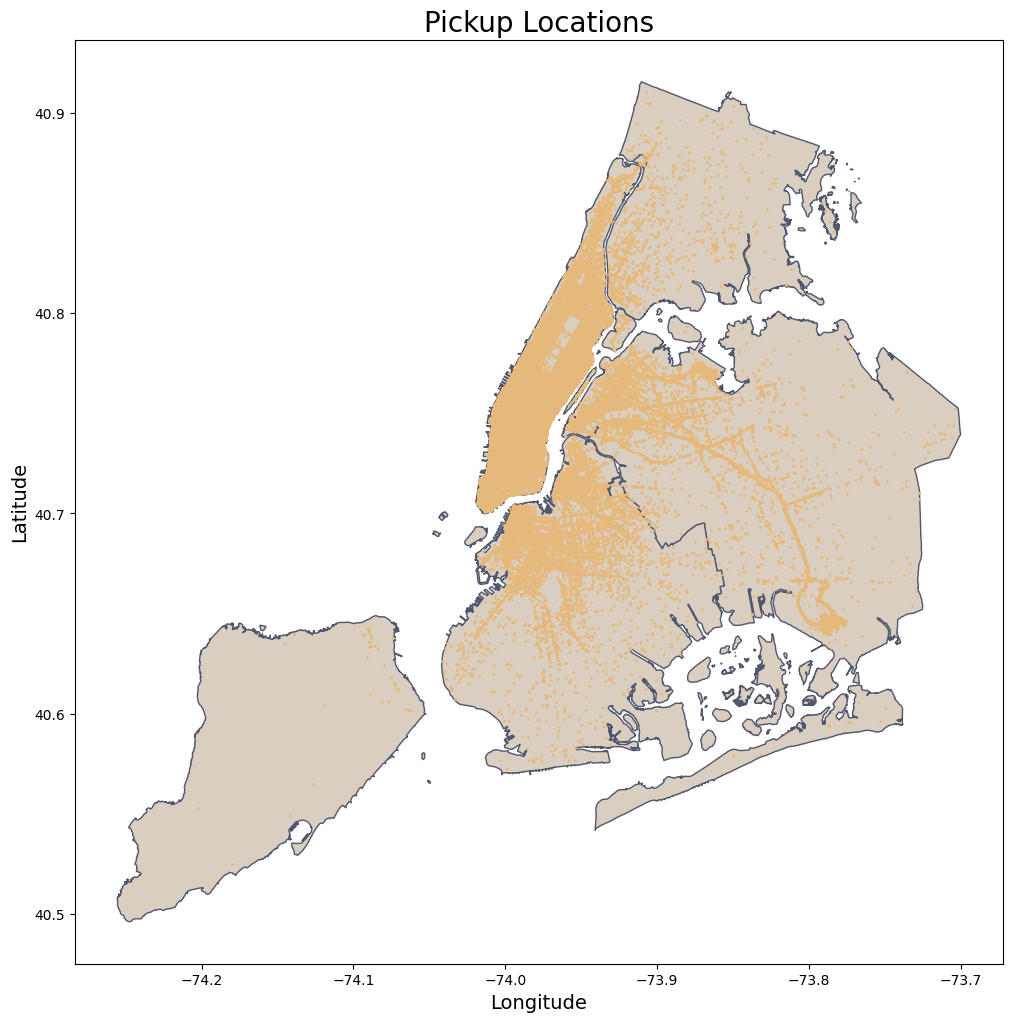

Number of outliers removed:1216


In [110]:
nybb_path = '../data/external/nyc-borough-boundaries/geo_export_e13eede4-6de2-4ed8-98a0-58290fd6b0fa.shp'
nyc_boundary = gpd.read_file(nybb_path)

geometry = gpd.points_from_xy(  trip_outliers['pickup_longitude'], 
                                trip_outliers['pickup_latitude'])

pickup_within_nyc = plot_points_map(   trip_outliers, nyc_boundary, geometry,  
                                'Pickup Locations')

print(f'Number of outliers removed:{len(trip_outliers)- len(pickup_within_nyc)}' )

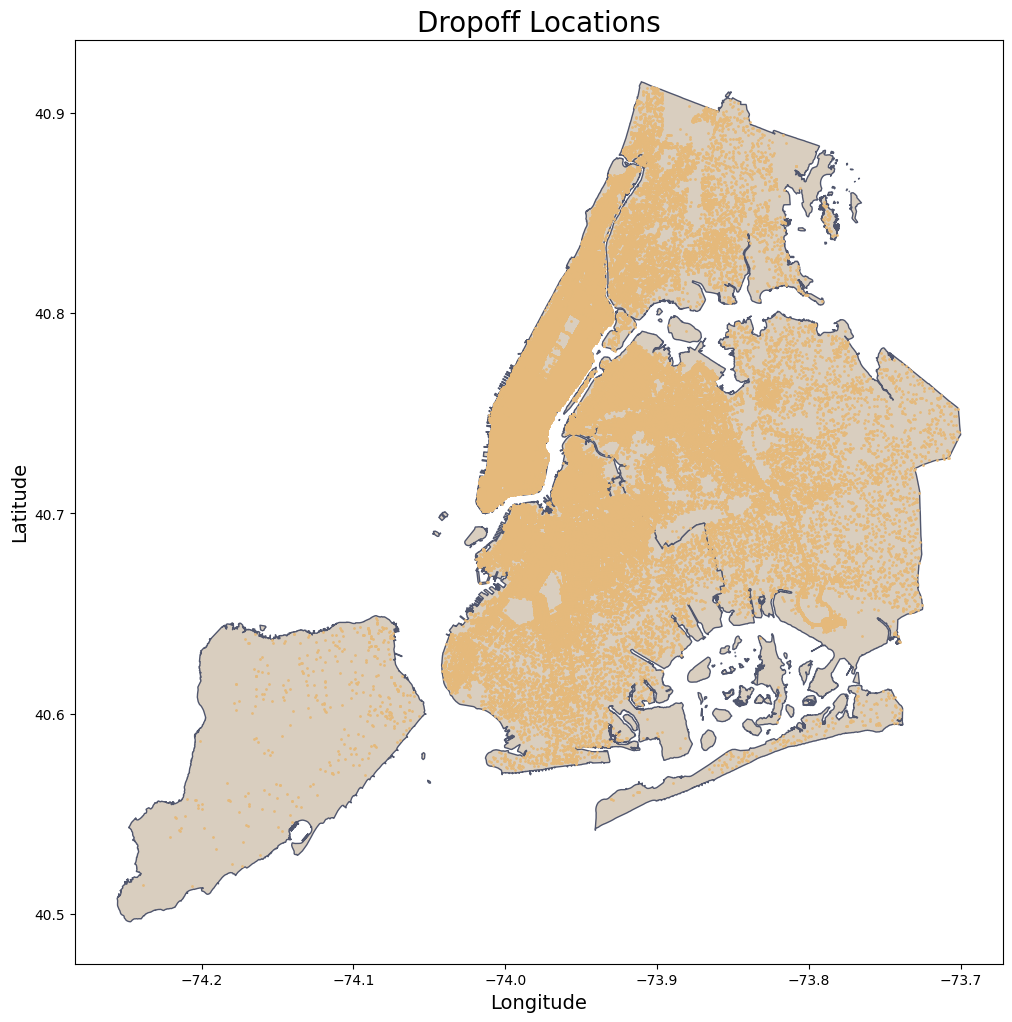

Number of outliers removed:5359


In [111]:
geometry = gpd.points_from_xy(pickup_within_nyc['dropoff_longitude'], 
                                pickup_within_nyc['dropoff_latitude'])

pickup_dropoff_within_nyc = plot_points_map(   pickup_within_nyc, nyc_boundary, geometry, 
                                'Dropoff Locations', color_points = orange)

print(f'Number of outliers removed:{len(pickup_within_nyc) - len(pickup_dropoff_within_nyc)}' )

## 2.2. Target Feature (Trip Duration)

In [112]:
# Copy the dataset with removed outliers from locations
trip_outliers = pickup_dropoff_within_nyc.copy()

**The interquartile range (IQR)**

The IQR gives a sense of how spread out the values in a dataset are and is a robust measure of dispersion that is not influenced by outliers.

A quartile divides data into four equal parts, each comprising 25% of the data. $Q_1$ represents the 25th percentile of the data, meaning 25% of data points are less than or equal to this value. $Q_3$ represents the 75th percentile, implying that 75% of data points are less than or equal to this value.

Let's calculate the IQR for the target feature `trip_duration` and plot a blox plot to visualize the outliers:


In [113]:
def boxplot_stats(series, whis = 1.5):
    """
    Calculate the statistics for a box plot.

    Returns:
    dict: A dictionary containing the quartiles, IQR, and whisker limits.
    """
    Q1 = series.quantile(0.25)
    Q2 = series.quantile(0.50)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - whis * IQR
    upper_whisker = Q3 + whis * IQR

    return {
        'Q1': Q1,
        'Q2': Q2,
        'Q3': Q3,
        'IQR': IQR,
        'lower_whis': lower_whisker,
        'upper_whis': upper_whisker
    }

In [114]:
def plot_distribution_boxplot(  series, title = ' ', label = ' ', 
                                figsize=(15, 8), log1p = True, 
                                draw_quartiles=True, kde = True):
    """
    Plot the distribution and boxplot of a series.

    Args:
    series (pandas.Series): The series to plot.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    figsize (tuple): The size of the figure.
    """
    # Calculate the log of the series
    if log1p:
        series = np.log1p(series)
    stats = boxplot_stats(series)

    # Setup the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot the histogram on the first axes
    sns.histplot(  series, bins=40, linewidth=0.5, color=yellow, alpha=0.2,
                    ax=axes[0], kde = kde, line_kws={'lw': 3})
    axes[0].set_title(f'{title} Histogram', fontsize=15)
    axes[0].set_xlabel(label, fontsize=14)
    axes[0].set_ylabel('Count', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)

    # Plot the boxplot on the second axes
    sns.boxplot(    data=series, color=yellow, ax=axes[1],
                    fliersize=3, flierprops={'color': grey, 'markeredgecolor': grey})
    axes[1].set_title(f'{title} Boxplot', fontsize=15)
    axes[1].set_ylabel(label, fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)

    # Draw quartile lines on the histogram
    if draw_quartiles:
        quartiles = [stats['Q1'], stats['Q3'], stats['lower_whis'], stats['upper_whis']]
        for line in quartiles:
            axes[0].axvline(line, color=grey, linestyle='--', alpha=1, lw=2)
            y_center = axes[0].get_ylim()[1] / 2
            axes[0].text(line, y_center, f'{line:.2f}',
                        fontsize=18, color='black', va='center', ha='right', rotation=90)

    # Layout and show plot
    plt.tight_layout()
    plt.show()

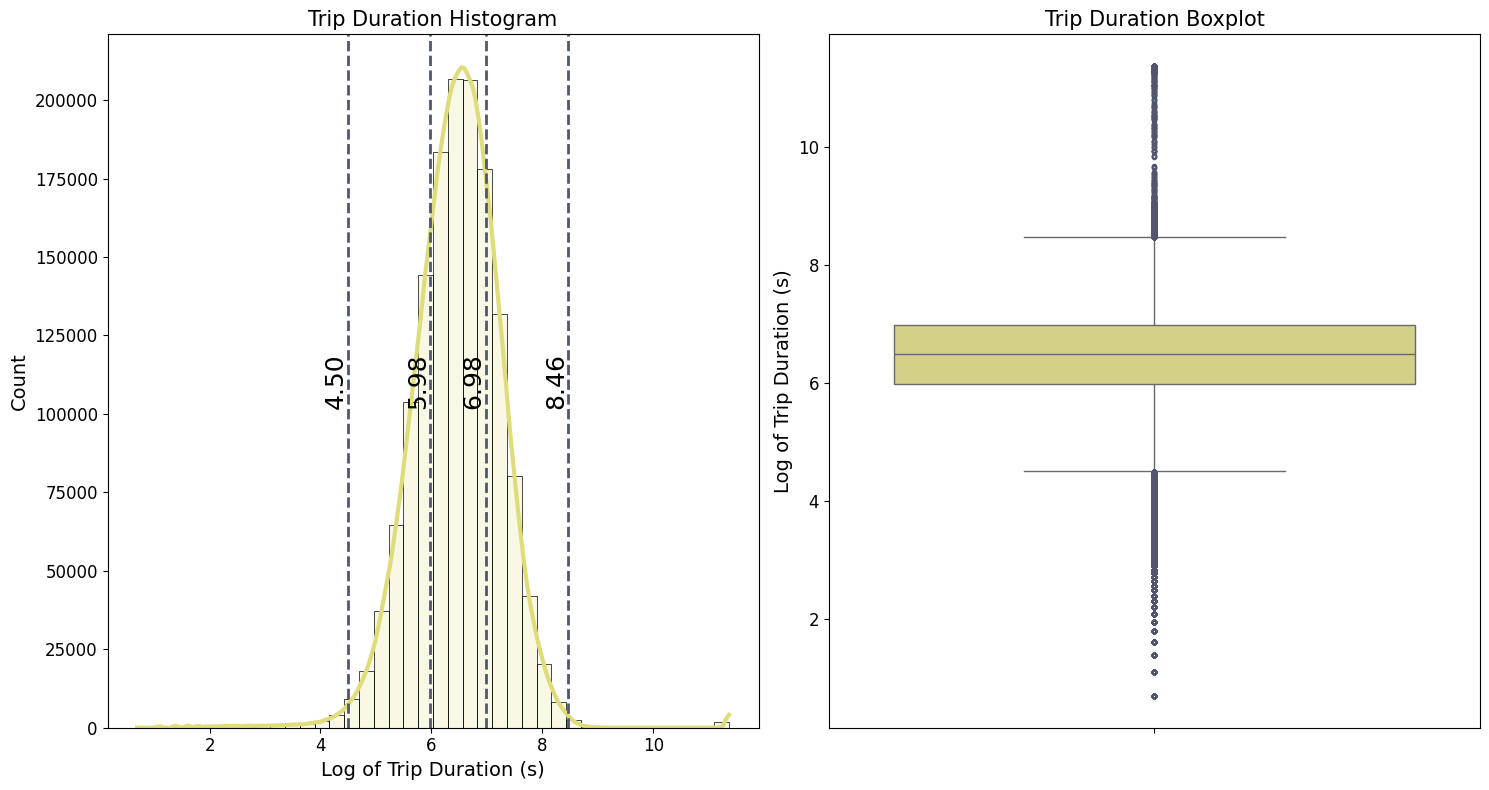

In [115]:
plot_distribution_boxplot(trip_outliers['trip_duration'],
                        'Trip Duration', 'Log of Trip Duration (s)')

Because of the high values and zeros in the target feature `trip_duration`, we apply the logarithmic transformation $\log(x+1)$. This transformation effectively reduces influence of outliers and variance.The histogram, illustrated in the first plot, resembles a bell curve after applying this transformation. From the boxplot, we can see:

- The first and third quartiles ($Q_1$ and $Q_3$) representing the 25th and 75th percentiles, are:

  - $Q_1 = 5.99$
  - $Q_3 = 6.98$

- The interquartile range (IQR) is the difference between the third and first quartiles:
  - IQR = $Q_3 - Q_1 = 0.99$

- The whiskers indicate the range of the data:
  - The lower whisker :  $Q_1 - 1.5 IQR = 4.49$
  - The upper whisker :  $Q_3 + 1.5 IQR = 8.47$

Data points outside the whiskers are potential outliers that need further validation. For better intuition, we convert these whisker values from the log scale back to the original scale in terms of hours ($\text{Hours} = \text{Seconds}/3600$ ):

$$\frac{\exp(4.50) - 1}{3600} \approx  0.024 ~~\text{hours}$$
$$\frac{\exp(8.46) - 1}{3600} \approx  1.32 ~~\text{hours}$$

The lower whisker corresponds to approximately 1.4 minutes, which is very short for a taxi trip duration, suggesting that these could be errors or special cases.The upper whisker suggests a more plausible trip duration of about 1.32 hours, but with very unrealistic high values with more than 20 hours of duration. 

In [116]:
def count_outliers(series, whis = 1.5):
        """
        Count the number of upper and lower outliers in the series and print their percentages.

        Args:
        series (pd.Series): Series for which to count outliers.

        Returns:
        (pd.Series, pd.Series): Two boolean series, one for upper outliers and one for lower outliers.
        """

        stats = boxplot_stats(series, whis)


        upper_outliers = (series > stats['upper_whis'])
        lower_outliers = (series < stats['lower_whis'])

        # Percentage of outliers 
        percentage_upper = upper_outliers.sum() / len(series) * 100
        percentage_lower = lower_outliers.sum() / len(series) * 100

        print(  f'\nPotential upper outliers: {upper_outliers.sum()} '
                f'({percentage_upper:.2f}% of the dataset)')

        print(  f'\nPotential lower outliers: {lower_outliers.sum()} '
                f'({percentage_lower:.2f}% of the dataset)')

        return upper_outliers, lower_outliers

In [117]:
log_trip_duration = np.log1p(trip_outliers['trip_duration'])
upper_duration_outliers, lower_duration_outliers = count_outliers(log_trip_duration)


Potential upper outliers: 4292 (0.30% of the dataset)

Potential lower outliers: 14461 (1.00% of the dataset)



Let's compare the trip durations with some distance measures from the pickup location to the dropoff location. In an article on [New York City taxi trip duration prediction using MLP and XGBoost](https://link.springer.com/article/10.1007/s13198-021-01130-x), some distance measures were discussed, like Manhattan, haversine, and bearing distances. Unlike the straight-line Euclidean distance, the Manhattan distance calculates the sum of the absolute differences between the horizontal and vertical coordinates, which resembles navigating an actual grid of city streets.  However, this doesn't account for the Earth's curvature. To address this, the article also considers the haversine distance, which is more appropriate for large distances as it does account for the Earth's curvature. Bearing distance calculates the direction between two points.

I will just adopt a simplified approach that still accounts for the Earth's curvature. This will involve calculating the geodesic distance using the `geopy` library:

In [118]:
# Function to calculate geodesic distance in a ellipsoid
def geodesic(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    distances = [ distance.distance( (lat1, lon1), (lat2, lon2) ).meters for lat1, lon1, lat2, lon2 
                                                            in  zip(pickup_lat, pickup_long, 
                                                                    dropoff_lat, dropoff_long) ]
    return distances

# Calculate the geodesic distance
geodesic_distance = geodesic(   trip_outliers['pickup_latitude'].to_numpy(), 
                                trip_outliers['pickup_longitude'].to_numpy(), 
                                trip_outliers['dropoff_latitude'].to_numpy(), 
                                trip_outliers['dropoff_longitude'].to_numpy())

**Potential Lower Outliers**

Approximately 1% of all trips have durations less than or equal to 1.4 minutes. Based on the table below, it appears that some of these trips may have been canceled, as indicated by a zero or minimal geodesic distance. Because our analysis aims to predict the trip duration, we will remove these potentially canceled trips from the dataset.

In [119]:

trip_outlier_geodesics = trip_outliers.copy()
trip_outlier_geodesics['geodesic_distance'] = geodesic_distance

display(    trip_outlier_geodesics[lower_duration_outliers]
            .groupby('passenger_count')[['trip_duration', 'geodesic_distance']]
            .agg(['min', 'mean','max',  'count'])   )

trip_duration                       geodesic_distance  \
                          min       mean max  count               min   
passenger_count                                                         
1                           1  47.663972  88  11258               0.0   
2                           1  51.322023  88   1562               0.0   
3                           2  53.269321  88    427               0.0   
4                           2  53.846890  88    209               0.0   
5                           2  55.686591  88    619               0.0   
6                           2  57.704663  88    386               0.0   

                                                  
                       mean           max  count  
passenger_count                                   
1                272.870639  19983.682930  11258  
2                299.515846   1823.852419   1562  
3                315.255005   1491.261959    427  
4                302.298194   1665.249710    209  
5                347.513153   1509.483335    619  
6                364.417960   1120.139579    386

**Potential Upper Outliers**

Approximately 0.30% of all trips have durations of 1.32 hours or less. In this case, a table alone does not give much information about these potential outliers; therefore, we employ a histogram to better visualize these potential upper outliers.

From the histogram, it is apparent that around 1700 trips have durations exceeding 20 hours. In contrast, a larger cluster of over 2000 trips has durations ranging between 1.32 hours and 4 hours. Considering this distribution, only those with durations longer than 4 hours may be classified as actual outliers, as durations less than 4 hours are within a plausible range for taxi trips in NYC.

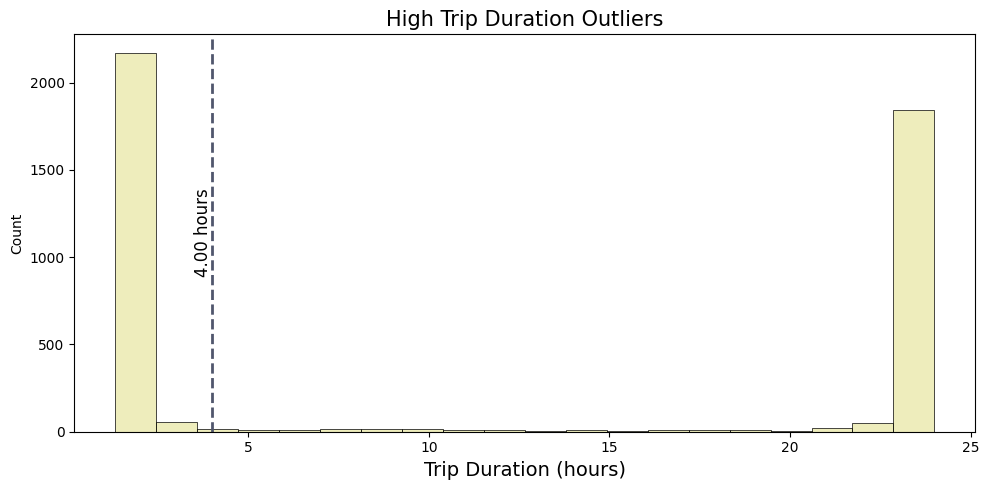

In [120]:
upper_outliers = trip_outliers[upper_duration_outliers]['trip_duration'].reset_index(drop=True)/3600
#plot_distribution_boxplot( upper_outliers, kde = False, draw_quartiles=False)

fig, axes = plt.subplots(1, 1, figsize= (10, 5))

# Plot the histogram on the first axes
sns.histplot(  upper_outliers, bins=20, linewidth=0.5, color=yellow, alpha=0.5)

axes.set_title(f'High Trip Duration Outliers', fontsize=15)
axes.set_xlabel('Trip Duration (hours)', fontsize=14)
axes.axvline(4, color=grey, linestyle='--', alpha=1, lw=2)
y_center = axes.get_ylim()[1] / 2
axes.text(4, y_center, f'{4:.2f} hours',
            fontsize=12, color='black', va='center', ha='right', rotation=90)
plt.tight_layout()
plt.show()

We observed that there are also unrealistic values for `geodesic_distance`. These unrealistic values can simple be deleted because they don't represent a real patters for the trip duration. We'll create variables to hold boolean series for each of the identified outliers conditions:

In [121]:
# Percentage of lower duration outliers
per_lower_duration = lower_duration_outliers.sum() / len(trip_outliers) * 100
print(f'\nOutliers with trip duration less than 1.4 minutes: {lower_duration_outliers.sum()} '
      f'({per_lower_duration:.2f}% of the dataset)')


# Boolean series for trip durations over 4 hours
upper_duration_outliers = trip_outliers['trip_duration'] > 4 * 3600
per_upper_duration = upper_duration_outliers.sum() / len(trip_outliers) * 100

print(f'\nOutliers with trip duration greater than 4 hours: {upper_duration_outliers.sum()} '
      f'({per_upper_duration:.2f}% of the dataset)')


# Boolean series for geodesic distance == zero
geodesic_outliers_zeros = (trip_outlier_geodesics['geodesic_distance'] == 0)
# Percentage of outliers
per_geodesic = geodesic_outliers_zeros.sum() / len(taxi_trip) * 100

print(f'\nOutliers with zero geodesic distances: {geodesic_outliers_zeros.sum()} '
      f'({per_geodesic:.2f}% of the dataset)')



Outliers with trip duration less than 1.4 minutes: 14461 (1.00% of the dataset)

Outliers with trip duration greater than 4 hours: 2059 (0.14% of the dataset)

Outliers with zero geodesic distances: 5490 (0.38% of the dataset)


**Average Geodesic Velocity**

Before removing all this outliers that we identify, let's first investigate one more aspect of the trip duration. As direct observations may not be sufficient to identify all outliers, we can calculate an average velocity based on the geodesic distances to provide a better understanding of potential outliers.

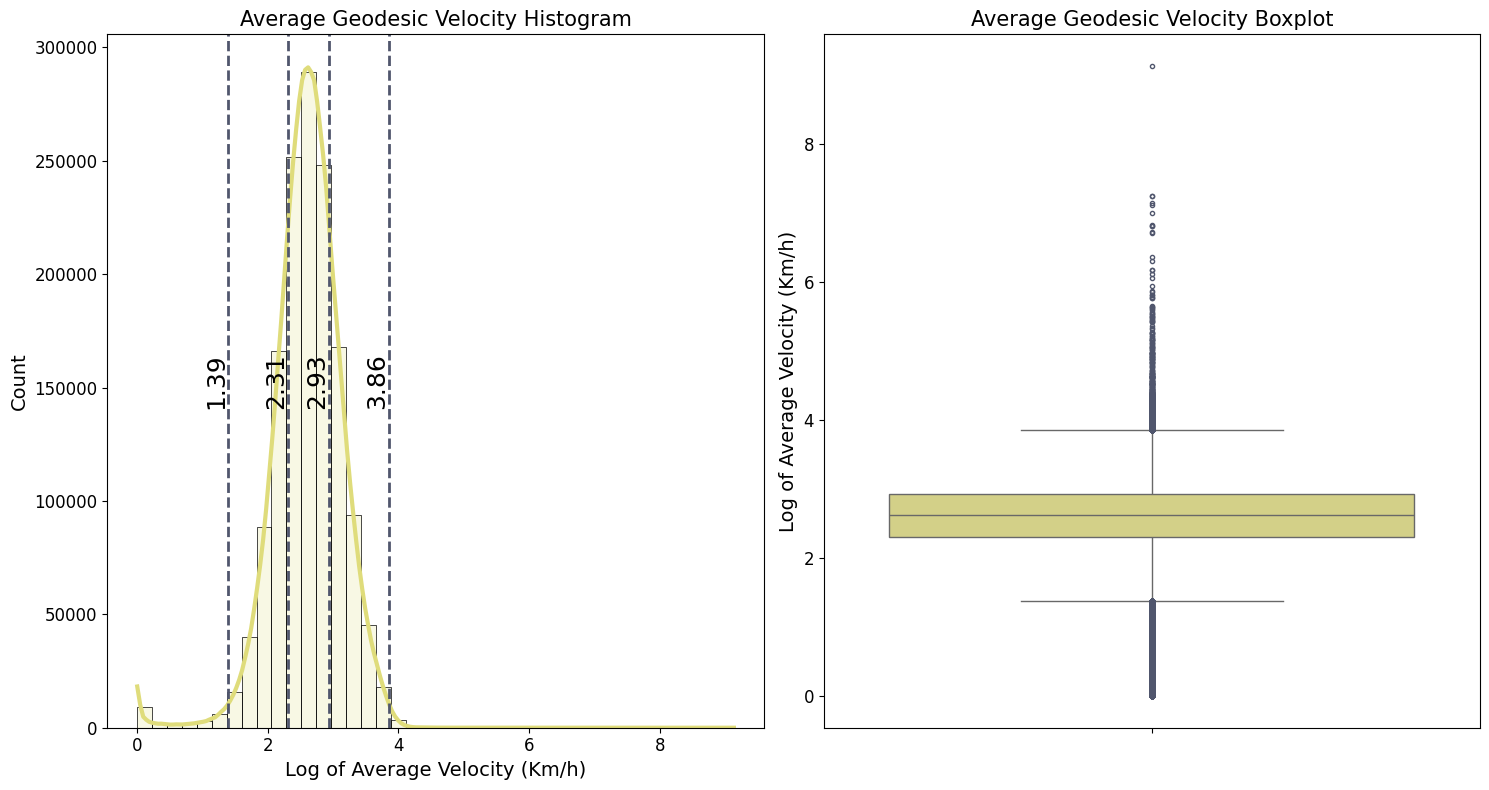


Potential upper outliers: 4950 (0.34% of the dataset)

Potential lower outliers: 23999 (1.65% of the dataset)


In [122]:

# Calculate the average velocity in Km/h
geo_distance_km = trip_outlier_geodesics['geodesic_distance']/1000
trip_duration_hrs = trip_outlier_geodesics['trip_duration']/3600
velocity_geodesic_kmh = (geo_distance_km) / (trip_duration_hrs)

# For simplicity add velocity to the dataset
trip_outlier_geodesics['avg_velocity_kmh'] = velocity_geodesic_kmh

plot_distribution_boxplot(trip_outlier_geodesics['avg_velocity_kmh'], 
                        'Average Geodesic Velocity', 
                        'Log of Average Velocity (Km/h)')

log_velocity_geodesic = np.log1p(velocity_geodesic_kmh)
upper_vel_outliers, lower_vel_outliers = count_outliers(log_velocity_geodesic)

The lower and upper values for potential outliers are:

- Lower whisker : ${\exp(1.39) - 1} \approx  3.0 ~~ km/h $
- Upper whisker : ${\exp(3.86) - 1} \approx  46.5 ~~ km/h $

New York City is a metropolis known for its traffic congestion. The average speed of a taxi in New York City with passengers on board is 20.3 km/h, as reported in the article "[Taxi driver speeding](https://www.researchgate.net/publication/320479557_Taxi_driver_speeding_who_when_where_and_how_A_comparative_study_between_Shanghai_and_New_York)":

"... The average occupancy speed of taxi drivers in Shanghai (21.3 km/h) was similar to that of **NYC (20.3 km/h)**"

Considering that approximately 0.35% of the total number of trips have an average velocity greater than or equal to 46.5 km/h, these cases are not representative of typical taxi trips in NYC and thus can be removed.

 ### 3.1.1 Handling Outliers

We will now address the outliers identified in the target feature trip_duration using the following steps

1. Remove the `trip_duration`  less then or equal to 1.4 minutes. This will remove 1.00% of instances from the original dataset.

2. Remove the `trip_duration`  greater than 4 hours. This will remove 0.14% of instances from the original dataset.

3. Remove `geodesic_distance`  equal to 0.0 meters. This will remove 0.38% of instances from the original dataset.

4. Remove the `trip_duration` corresponding to an average velocity greater than or equal to 46.5 km/h.  This will remove 0.34% of instances from the original dataset.

We will use the boolean series previously defined to create a single series that identifies an entry as an outlier if it meets any one of the outlier conditions:

In [123]:
# Combine all outlier conditions
all_outliers =  lower_duration_outliers | upper_duration_outliers \
                | geodesic_outliers_zeros | upper_vel_outliers

not_outliers = ~all_outliers

# filter the original by not_outliers
original_length = len(taxi_trip)

per_outliers = all_outliers.sum()/original_length * 100
print(  f'\nOutliers removed: {all_outliers.sum()} '
        f'({per_outliers:.2f}% of the dataset)')


Outliers removed: 24848 (1.70% of the dataset)


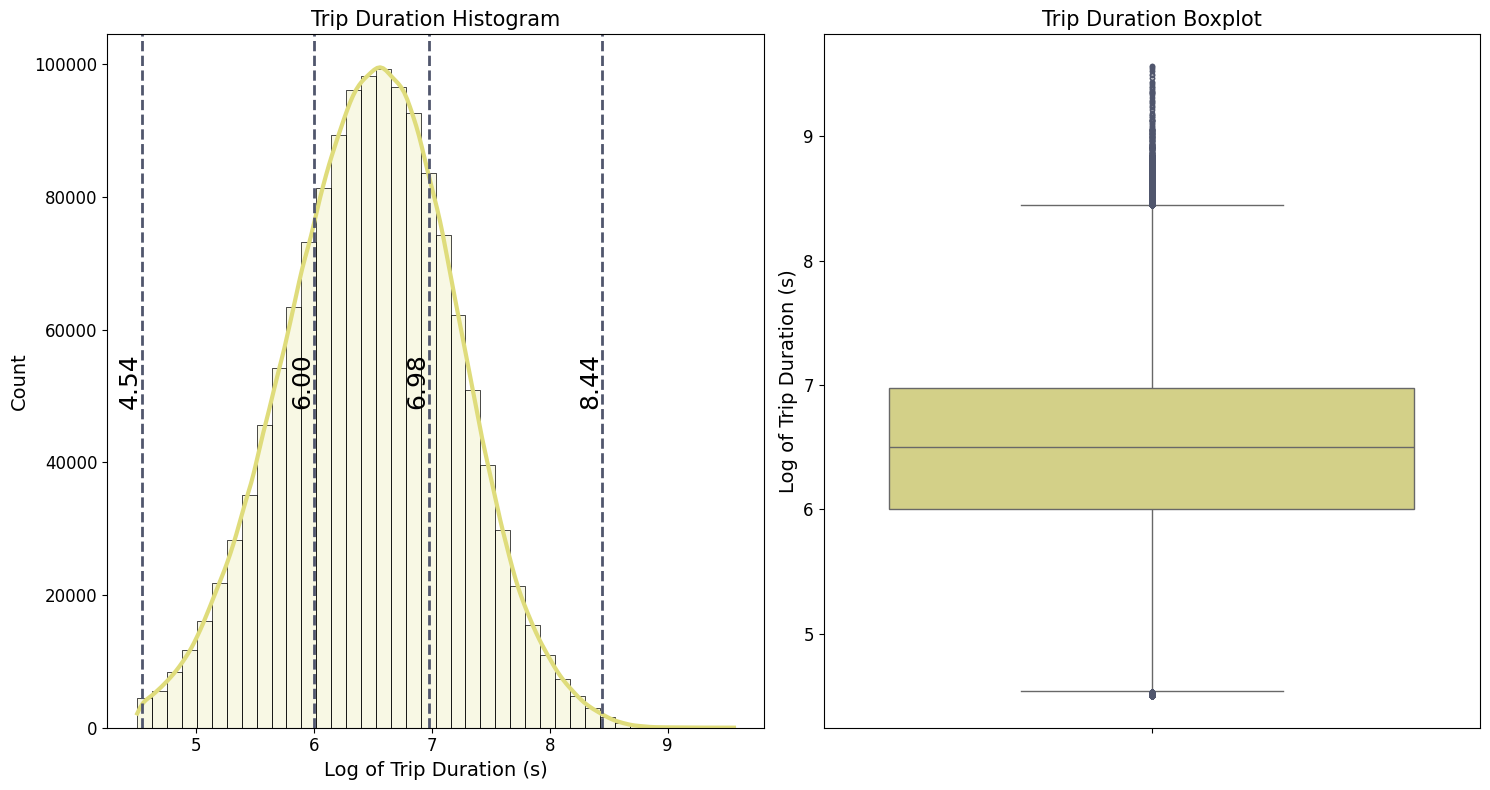

In [124]:
taxi_trip = trip_outliers[not_outliers].copy()
plot_distribution_boxplot(taxi_trip['trip_duration'],
                        'Trip Duration', 'Log of Trip Duration (s)')

# **3. Feature Engineering**

Before splitting the dataset and conducting the exploratory data analysis (EDA), let's create some new features that will help in the model predictions and in the EDA.

## 3.1. Datetime Features

Using the pickup time with format `YYYY-MM-DD H:M:S`, let’s extract features like the year, month, day, hours and minutes for more informative features and also the time of day, day of the week, day of the year to help with possible underlying patters in the data related to specific time intervals. So we will create a total of 8 new features:

In [125]:
# Days in a year: 1-365 (or 366)
taxi_trip['day_of_year'] = taxi_trip['pickup_datetime'].dt.dayofyear
# Day of week: 0-6 (0 for Monday, 6 for Sunday)
taxi_trip['day_of_week'] = taxi_trip['pickup_datetime'].dt.dayofweek
# Minutes in a day: 0-1440
taxi_trip['min_of_day'] = (taxi_trip['pickup_datetime'].dt.hour * 60) + taxi_trip['pickup_datetime'].dt.minute

# Date features
taxi_trip['year'] = taxi_trip['pickup_datetime'].dt.year
taxi_trip['month'] = taxi_trip['pickup_datetime'].dt.month
taxi_trip['day'] = taxi_trip['pickup_datetime'].dt.day
taxi_trip['hour'] = taxi_trip['pickup_datetime'].dt.hour
taxi_trip['minute'] = taxi_trip['pickup_datetime'].dt.minute

taxi_trip.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_year,day_of_week,min_of_day,year,month,day,hour,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,455,74,0,1044,2016,3,14,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,663,164,6,43,2016,6,12,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,2124,19,1,695,2016,1,19,11,35


Another relevant information is weekends and holidays. For this we will use the [holiday dataset from kaggle](https://www.kaggle.com/datasets/pceccon/nyc2016holidays/data), which contains the New York City holidays for the year of 2016. We will create two new binary features, `is_holiday` and `is_weekend`:

In [126]:
holidays = pd.read_csv('../data/raw/nyc-holidays-2016.csv', sep = ';')
display(holidays.head())

,Day,Date,Holiday
0,Friday,January 01,New Years Day
1,Monday,January 18,Martin Luther King Jr. Day
2,Friday,February 12,Lincoln's Birthday
3,Monday,February 15,Presidents' Day
4,Sunday,May 08,Mother's Day


In [127]:
# Convert to datetime the Date column
holidays['Date'] = pd.to_datetime(holidays['Date'] + ', 2016')

# Extract month and day as numerical values
holidays['month'] = holidays['Date'].dt.month
holidays['day'] = holidays['Date'].dt.day
# Add the is_holiday column 
holidays['is_holiday'] = True

# Drop the original columns
holidays.drop(['Date', 'Day', 'Holiday'], axis=1, inplace=True)

# Save the processed holidays dataset
holidays.to_csv('../data/external/nyc-holidays-2016.csv',index=False)

display(holidays.head())

,month,day,is_holiday
0,1,1,True
1,1,18,True
2,2,12,True
3,2,15,True
4,5,8,True


We will then use the `month` and `day` features to merge the taxi trip dataset with the holidays dataset using a left join:

In [128]:
# Merge the taxi data with the holidays data
taxi_trip = taxi_trip.merge(holidays, on=['month', 'day'], how='left')

# Replace NaN values in the is_holiday column with False
taxi_trip['is_holiday'].fillna(False, inplace=True)

# Add the is_weekend column (5:Saturday or 6:Sunday)
taxi_trip['is_weekend'] = taxi_trip['day_of_week'].isin([5, 6])

display(taxi_trip.head())
print('Number of trips in holiday:', taxi_trip[taxi_trip['is_holiday'] == True].shape[0])

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,day_of_year,day_of_week,min_of_day,year,month,day,hour,minute,is_holiday,is_weekend
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,74,0,1044,2016,3,14,17,24,False,False
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,...,164,6,43,2016,6,12,0,43,False,True
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,...,19,1,695,2016,1,19,11,35,False,False
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,False,...,97,2,1172,2016,4,6,19,32,False,False
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,False,...,86,5,810,2016,3,26,13,30,False,True


Number of trips in holiday: 49736


## 3.2. Traffic Features

A brief search on Google about New York City's traffic patterns revealed useful insights from sources such as [A Guide to Traffic in NYC](https://www.uber.com/blog/new-york-city/the-drivers-guide-to-traffic-in-a-new-york-minute/) and in [10 Tips to Beat NYC Traffic](https://intellishift.com/resources/blog/10-tips-to-beat-nyc-traffic/) sites. These resources suggest that high traffic times in and out of Manhattan typically occur between 8-9 a.m. and 3-7 p.m. Based on this information, we will create a new feature called `is_rush_hour`  to determine whether the pickup time falls within rush hour on a given day of the week. To simplify, weekends and holidays will be considered as having normal traffic hours throughout the day.

In [129]:
# Define rush hours
morning_rush = (taxi_trip['hour'] >= 8) & (taxi_trip['hour'] < 9)
evening_rush = (taxi_trip['hour'] >= 15) & (taxi_trip['hour'] < 20)

# Weekdays are 0 (Monday) to 4 (Friday)
is_weekday = taxi_trip['day_of_week'] < 5


taxi_trip['is_rush_hour'] = (morning_rush | evening_rush) & is_weekday

display(taxi_trip.head(3))

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,day_of_week,min_of_day,year,month,day,hour,minute,is_holiday,is_weekend,is_rush_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,0,1044,2016,3,14,17,24,False,False,True
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,...,6,43,2016,6,12,0,43,False,True,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,...,1,695,2016,1,19,11,35,False,False,False


## 3.3. Distance Features

In an article on [New York City taxi trip duration prediction using MLP and XGBoost](https://link.springer.com/article/10.1007/s13198-021-01130-x), as discussed in the outliers section, some distance measures were discussed, like Manhattan, haversine, and bearing distances. 

For this project, I will adopt a simplified approach that still accounts for the Earth's curvature. This will involve calculating the geodesic distance using the geopy library and computing the bearing distance. The bearing distance measures the angle between the north line and the line connecting the pickup and drop-off locations.

In [130]:
# Function to calculate geodesic distance in a ellipsoid
def geodesic_distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    distances = [ distance.distance( (lat1, lon1), (lat2, lon2) ).meters for lat1, lon1, lat2, lon2 
                                                            in  zip(pickup_lat, pickup_long, 
                                                                    dropoff_lat, dropoff_long) ]
    return distances

taxi_trip['geodesic_distance'] = geodesic_distance( taxi_trip['pickup_latitude'].to_numpy(), 
                                                    taxi_trip['pickup_longitude'].to_numpy(), 
                                                    taxi_trip['dropoff_latitude'].to_numpy(), 
                                                    taxi_trip['dropoff_longitude'].to_numpy())


def bearing(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the change in coordinates
    dlon = lon2 - lon1

    # Calculate bearing
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    initial_bearing = np.arctan2(x, y)

    # Convert from radians to degrees and normalize (0-360)
    initial_bearing = np.degrees(initial_bearing)
    bearing = (initial_bearing + 360) % 360

    return bearing

# Applying the function to calculate bearing distance
taxi_trip['bearing'] = bearing( taxi_trip['pickup_latitude'], taxi_trip['pickup_longitude'], 
                                taxi_trip['dropoff_latitude'], taxi_trip['dropoff_longitude'])


#taxi_trip.to_csv('../data/interim/nyc-taxi-trip-2016-intermediate.csv', index=False)
display(taxi_trip.head(3))

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,year,month,day,hour,minute,is_holiday,is_weekend,is_rush_hour,geodesic_distance,bearing
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,2016,3,14,17,24,False,False,True,1502.171837,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,...,2016,6,12,0,43,False,True,False,1808.659969,242.846232
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,...,2016,1,19,11,35,False,False,False,6379.687175,200.319835


## 3.4. Weather Features

Even small weather changes, like rain or snow, can significantly affect traffic and transportation patterns in a large city. Rain or snow can impact driving conditions, increase traffic congestion, and influence public transportation usage, leading to longer taxi trip times and potentially higher demand for taxis. Therefore, we will use the
[weather dataset from kaggle](https://www.kaggle.com/datasets/cabaki/knycmetars2016). This dataset includes information on temperature, precipitation, visibility, and other relevant weather metrics. We plan to integrate this data with our taxi trip dataset by merging them based on date and time as we did before with the holidays dataset.

In [131]:
weather = pd.read_csv('../data/raw/nyc-weather-2016.csv', parse_dates=['Time'])
display(weather.head(3))

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,NaN,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,NaN,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,NaN,Overcast


The weather dataset shows some missing values in features like `Windchill`, `Heat Index`, `Pressure`, and `Visibility`. For our analysis, `Visibility` is a critical feature due to its potential impact on driving conditions. The missing values in `Windchill` and `Heat Index` are not a concern for our study, as these factors are less directly related to traffic patterns. Other relevant features for our analysis, such as `Conditions` and `Temp.` have no missing values, and we do not need to worry.

In [132]:
# Checking for missing values, data types and duplicates:
print('duplicated values:', weather.duplicated().sum())
print('\n')
display(weather.info())
print('\n')
display(weather.isnull().sum()) 


duplicated values: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time        8787 non-null   datetime64[ns]
 1   Temp.       8787 non-null   float64       
 2   Windchill   2295 non-null   float64       
 3   Heat Index  815 non-null    float64       
 4   Humidity    8787 non-null   float64       
 5   Pressure    8556 non-null   float64       
 6   Dew Point   8787 non-null   float64       
 7   Visibility  8550 non-null   float64       
 8   Wind Dir    8787 non-null   object        
 9   Wind Speed  8787 non-null   float64       
 10  Gust Speed  8787 non-null   float64       
 11  Precip      8787 non-null   float64       
 12  Events      455 non-null    object        
 13  Conditions  8787 non-null   object        
dtypes: datetime64[ns](1), float64(10), object(3)
memory usage: 961.2+ KB


None

Time             0
Temp.            0
Windchill     6492
Heat Index    7972
Humidity         0
Pressure       231
Dew Point        0
Visibility     237
Wind Dir         0
Wind Speed       0
Gust Speed       0
Precip           0
Events        8332
Conditions       0
dtype: int64

The feature `Conditions` is a categorical feature that describes the weather conditions at the time of the observation. the feature have the following unique values of categorical data:

In [133]:
print(weather['Conditions'].unique())

['Overcast' 'Clear' 'Partly Cloudy' 'Mostly Cloudy' 'Scattered Clouds'
 'Unknown' 'Light Rain' 'Haze' 'Rain' 'Heavy Rain' 'Light Snow' 'Snow'
 'Heavy Snow' 'Light Freezing Fog' 'Light Freezing Rain' 'Fog']


This features can be used to create new binary features that indicate the presence of a specific weather condition. We can create new features as `snow`, `heavy_snow`, `rain`, `heavy_rain` that indicates whether it was snowing or raining at the time of the observation. to create this features, we first group the `Conditions` feature into 4 categories:

- Snow: Light Snow, Snow

- Heavy Snow: Heavy Snow,Lightning freezing fog,  Fog

- Rain: Light Rain, Rain

- Heavy Rain: Heavy Rain, Light Freezing Rain

The idea to group the conditions this way is to consider the conditions that can impact the traffic in a similar way. For example, I add Fog in Heavy Snow because it can affect the visibility in a similar way. The same for Light Freezing Rain and Heavy Rain.


To integrate weather data into the dataset of taxi trip, we must first preprocessed the weather dataset to align it with the taxi trip dataset. Let's separate the date and time into different columns for  `year`, `month`, `day`, `hour`. 

In [134]:
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hour'] = weather['Time'].dt.hour

# Select only the year of 2016
weather = weather[(weather['year'] == 2016)]

# Select only the months that have in the taxi dataset
months_taxi_trip = taxi_trip['month'].unique()
select_month = weather['month'].isin(months_taxi_trip)
weather = weather[select_month]


# Create new features based in the conditions column
snow = (weather['Conditions'] == 'Light Snow') | (weather['Conditions'] == 'Snow')
heavy_snow = (weather['Conditions'] == 'Heavy Snow') | (weather['Conditions'] == 'Light Freezing Fog')\
                                                    | (weather['Conditions'] == 'Fog')

rain = (weather['Conditions'] == 'Light Rain') | (weather['Conditions'] == 'Rain')
heavy_rain = (weather['Conditions'] == 'Heavy Rain') | (weather['Conditions'] == 'Light Freezing Rain') 

weather['snow'] = snow
weather['heavy_snow'] = heavy_snow
weather['rain'] = rain
weather['heavy_rain'] = heavy_rain

# Drop the features that are not needed
weather.drop([ 'Time', 'Windchill', 'Heat Index', 'Humidity', 'Pressure', 'Dew Point', 'Wind Dir',
                'Wind Speed', 'Events', 'Conditions', 'Gust Speed'], axis=1, inplace=True)

# Rename columns to lowercase as in the taxi dataset
weather.rename(columns={'Temp.': 'temperature'}, inplace=True)
weather.rename(columns={'Visibility': 'visibility'}, inplace=True)
weather.rename(columns={'Precip': 'precipitation'}, inplace=True)

display(weather.head(3))

,temperature,visibility,precipitation,year,month,day,hour,snow,heavy_snow,rain,heavy_rain
22,5.6,16.1,0.0,2016,1,1,0,False,False,False,False
23,5.6,16.1,0.0,2016,1,1,1,False,False,False,False
24,5.6,16.1,0.0,2016,1,1,2,False,False,False,False


We can check the maximum and minimum values for each feature to see if there is any inconsistency. As shown below, all features appear to be consistent with the range of values expected for each feature.

In [135]:
# max and min values
display(weather.describe().loc[['min', 'max']])

,temperature,visibility,precipitation,year,month,day,hour
min,-18.3,0.4,0.0,2016.0,1.0,1.0,0.0
max,32.2,16.1,11.9,2016.0,6.0,31.0,23.0


**Missing values**

We need to handle the missing values in visibility. This feature has values approximately between 0-16, where 0 indicates the worse visibility and 16 the best visibility. 

In [136]:
print('Unique values for visibility:\n', weather['visibility'].unique())
print('\n')
display(weather.isna().sum().head())

Unique values for visibility:
 [16.1  nan 14.5  8.  12.9 11.3  6.4  4.8  2.4  2.8  2.   4.   3.2  9.7
  1.2  0.8  1.6  0.4]




temperature        0
visibility       132
precipitation      0
year               0
month              0
dtype: int64

To better understand the nature of the missing values, let's create a table that correlates these missing values with different weather conditions. The missing values do not appear randomly distributed, they occur when the weather condition is good. To visualize this we can create a table that shows the number of `NaN` values in visibility named `is_visibility_nan` by the total number of days snowing and raining :

In [137]:
is_visibility_nan = weather['visibility'].isna()

weather_summary = pd.DataFrame({
    'is_visibility_nan': is_visibility_nan,
    '#snowing_days': snow,
    '#heavy_snowing_days': heavy_snow,
    '#raining_days': rain,
    '#heavy_raining_days': heavy_rain})

# Group by 'Visibility NaN' and calculate the sum for each weather condition
summary = weather_summary.groupby('is_visibility_nan').sum()

summary['total_counts'] =  is_visibility_nan.value_counts().values

# Reset index to turn 'Visibility NaN' back into a column
summary = summary.reset_index()


display(summary)


,is_visibility_nan,#snowing_days,#heavy_snowing_days,#raining_days,#heavy_raining_days,total_counts
0,False,61,6,171,10,4200
1,True,0,0,0,0,132


When `is_visibility_nan` is `True` (visibility data is missing), there are 132 days in total, and notably, none of these days are recorded as having snowing, heavy snowing, raining, or heavy raining conditions. This absence of precipitation-related weather conditions on days with missing visibility data suggests that visibility tends to be unrecorded primarily on days with good or clear weather. 

This could make sense, as maybe under clear conditions, they overlook recording some values. Therefore, we can logically fill the missing values with the maximum value of visibility.

In [138]:
weather['visibility'].fillna(weather['visibility'].max(), inplace=True)
print("Missing values in visibility: ",weather['visibility'].isna().sum())

Missing values in visibility:  0


We will use the combination of `year`, `month`, `day`, `hour` features to merge the taxi trip dataset with the weather dataset using a left join:

In [139]:
taxi_trip_merge = taxi_trip.merge(weather, on=['year','month', 'day', 'hour'], how='left')

display(taxi_trip_merge.isna().sum().tail(10))

# Save the weather dataset
weather.to_csv('../data/external/nyc-weather-2016.csv', index=False)
#taxi_trip.to_csv('../data/interim/nyc-taxi-trip-2016-intermediate.csv', index=False)

is_rush_hour             0
geodesic_distance        0
bearing                  0
temperature          11751
visibility           11751
precipitation        11751
snow                 11751
heavy_snow           11751
rain                 11751
heavy_rain           11751
dtype: int64

After merging the two datasets, we can see that there are some missing dates in the weather dataset, causing 11751 missing values for the weather features. This is less then 1% of our entire dataset, so we can take a more simplified approach by dropping these rows:

In [140]:
taxi_trip = taxi_trip_merge.dropna()

print('Old size:',taxi_trip_merge.shape[0])

print('\nNew size:',taxi_trip.shape[0])

# Save the taxi dataset
#taxi_trip.to_csv('../data/interim/nyc-taxi-trip-2016-intermediate.csv', index=False)

display(taxi_trip.head(3))

Old size: 1427156

New size: 1415405


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,is_rush_hour,geodesic_distance,bearing,temperature,visibility,precipitation,snow,heavy_snow,rain,heavy_rain
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,True,1502.171837,99.970196,4.4,8.0,0.3,False,False,False,False
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,...,False,1808.659969,242.846232,28.9,16.1,0.0,False,False,False,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,...,False,6379.687175,200.319835,-6.7,16.1,0.0,False,False,False,False


## 3.5 Cluster Centers Feature

Here we will use the mini-batch k-means algorithm to cluster the pickup and dropoff locations into 100 clusters. We will then use the cluster centers to create new features that represent the distance between the pickup and dropoff locations and the cluster centers. This will help the model to identify patterns in the data related to the cluster centers.

In [141]:
def plot_clusters_map(  df, gdf_map, latitude_col, longitude_col, cluster_col, ax, 
                        title=' ', sample_size=0, color_map= white, edgecolor= grey, 
                        random_state=42, cmap='tab20', alpha=0.2):
    
    if sample_size > 0:
        df = df.sample(sample_size, random_state=random_state)
        
    # Create geometry and GeoDataFrame
    geometry = gpd.points_from_xy(df[longitude_col], df[latitude_col])
    gdf_clusters = gpd.GeoDataFrame(df, geometry=geometry).set_crs(epsg=4326)
    
    # Convert map to the same CRS
    gdf_map = gdf_map.to_crs(epsg=4326)
    gdf_map.plot(ax=ax, color=color_map, edgecolor=edgecolor)  # Plot the NYC boundary
    
    # Scatter plot for clusters
    ax.scatter( gdf_clusters.geometry.x, gdf_clusters.geometry.y, s=1, 
                c=df[cluster_col].values, cmap=cmap, alpha=alpha)  # Plot clusters
    
    # Set labels and title
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_title(title, fontsize=20)
    
# Function to calculate geodesic distance in a ellipsoid
def geodesic_distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    distances = [ distance.distance( (lat1, lon1), (lat2, lon2) ).meters for lat1, lon1, lat2, lon2 
                                                            in  zip(pickup_lat, pickup_long, 
                                                                    dropoff_lat, dropoff_long) ]
    return distances

Let's create more six features based in the results of the mini-batch k-means algorithm. We will create two features for the predict clusters, one for pickup and one for dropoff locations. From this features we extract the longitude and latitude centers of each cluster, creating four features: `pickup_center_lat`, `pickup_center_long`, `dropoff_center_lat`, `dropoff_center_long`. We will also create two features for the distance between the pickup and dropoff cluster centers, `pickup_cluster_distance` and `dropoff_cluster_distance`. 

In [148]:

pickup_locations = taxi_trip[['pickup_latitude', 'pickup_longitude']].copy()
dropoff_locations = taxi_trip[['dropoff_latitude', 'dropoff_longitude']].copy()

coords = np.vstack( [pickup_locations.values, dropoff_locations.values])

# Randomly permute the combined coordinates 
sample_coords = np.random.permutation(coords)[:500000]

kmeans_coords = MiniBatchKMeans(    n_clusters= 100 , random_state=42, 
                                    batch_size=10000, n_init = 'auto')

kmeans_coords.fit(sample_coords)

# Predict clusters for the full dataset
taxi_trip.loc[:, 'pickup_cluster'] = kmeans_coords.predict(pickup_locations.values)
taxi_trip.loc[:, 'dropoff_cluster'] = kmeans_coords.predict(dropoff_locations.values)


cluster_centers = kmeans_coords.cluster_centers_
taxi_trip.loc[:, 'pickup_center_lat'] = cluster_centers[taxi_trip['pickup_cluster'], 0]
taxi_trip.loc[:, 'pickup_center_lon'] = cluster_centers[taxi_trip['pickup_cluster'], 1]
taxi_trip.loc[:, 'dropoff_center_lat'] = cluster_centers[taxi_trip['dropoff_cluster'], 0]
taxi_trip.loc[:,'dropoff_center_lon'] = cluster_centers[taxi_trip['dropoff_cluster'], 1]

# Calculate the geodesic distance
taxi_trip.loc[:,'center_geodesic_distances'] = geodesic_distance(   taxi_trip.loc[:,'pickup_center_lat'].to_numpy(), 
                                                                    taxi_trip.loc[:,'pickup_center_lon'].to_numpy(), 
                                                                    taxi_trip.loc[:,'dropoff_center_lat'].to_numpy(), 
                                                                    taxi_trip.loc[:,'dropoff_center_lon'].to_numpy())

In [144]:
taxi_trip[['center_geodesic_distances', 'geodesic_distance']].head()

,center_geodesic_distances,geodesic_distance
0,1575.134051,1502.171837
1,1842.019214,1808.659969
2,6783.770846,6379.687175
3,1661.759768,1483.632481
4,1707.442035,1187.037659


For a visualization, we can plot the clusters using the shape file from [NYC Borough Boundaries](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) and the cluster centers:

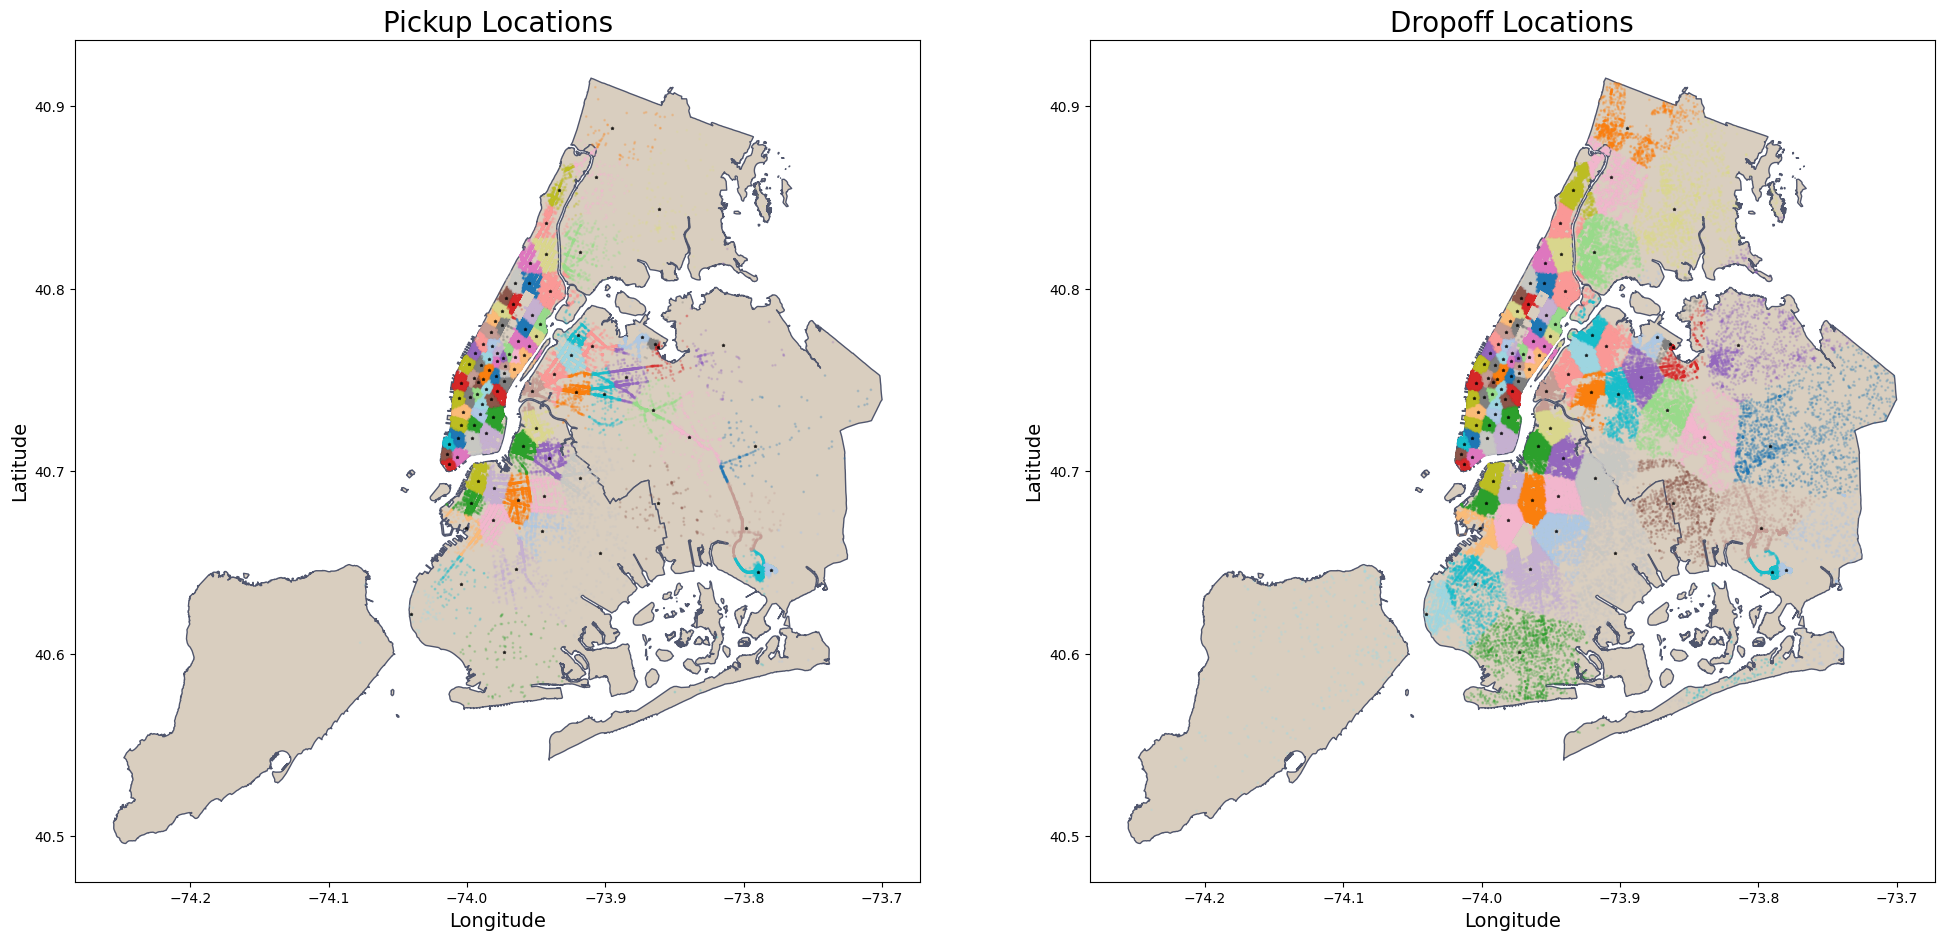

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(24, 16))
titles = ['Pickup Locations', 'Dropoff Locations']
# Column names 
location_columns = [('pickup_latitude', 'pickup_longitude', 'pickup_cluster'), 
                    ('dropoff_latitude', 'dropoff_longitude', 'dropoff_cluster')]

# Loop through each subplot
for ax, title, (lat_col, lon_col, cluster_col) in zip(axes, titles, location_columns):
    plot_clusters_map(  taxi_trip, nyc_boundary, lat_col, lon_col, cluster_col, ax, 
                        title=title, edgecolor=grey)
    
    # Plot the cluster centers
    ax.scatter( cluster_centers[:, 1], cluster_centers[:, 0], s = 3, 
                c = 'black', marker='*', alpha = 0.7)
    
plt.show()


In [149]:
# save the dataset
taxi_trip.to_csv('../data/interim/nyc-taxi-trip-2016-new-features.csv', index=False)

# **4. Split Dataset**

In [147]:
taxi_trip = pd.read_csv('../data/interim/nyc-taxi-trip-2016-new-features.csv')

In [204]:
# Split in 60% Train /20% Validation/ 20% Test
df_train_large, df_test = train_test_split(taxi_trip, test_size = 0.35, random_state = random_state)
df_train, df_val = train_test_split(df_train_large, train_size = 0.75, random_state = random_state)

# Save target feature
Y_train_large = df_train_large['trip_duration'].values
Y_test = df_test['trip_duration'].values
Y_train = df_train['trip_duration'].values
Y_val = df_val['trip_duration'].values

# Drop target feature 
df_train.drop('trip_duration', axis=1, inplace=True)
df_val.drop('trip_duration', axis=1, inplace=True)
df_test.drop('trip_duration', axis=1, inplace=True)

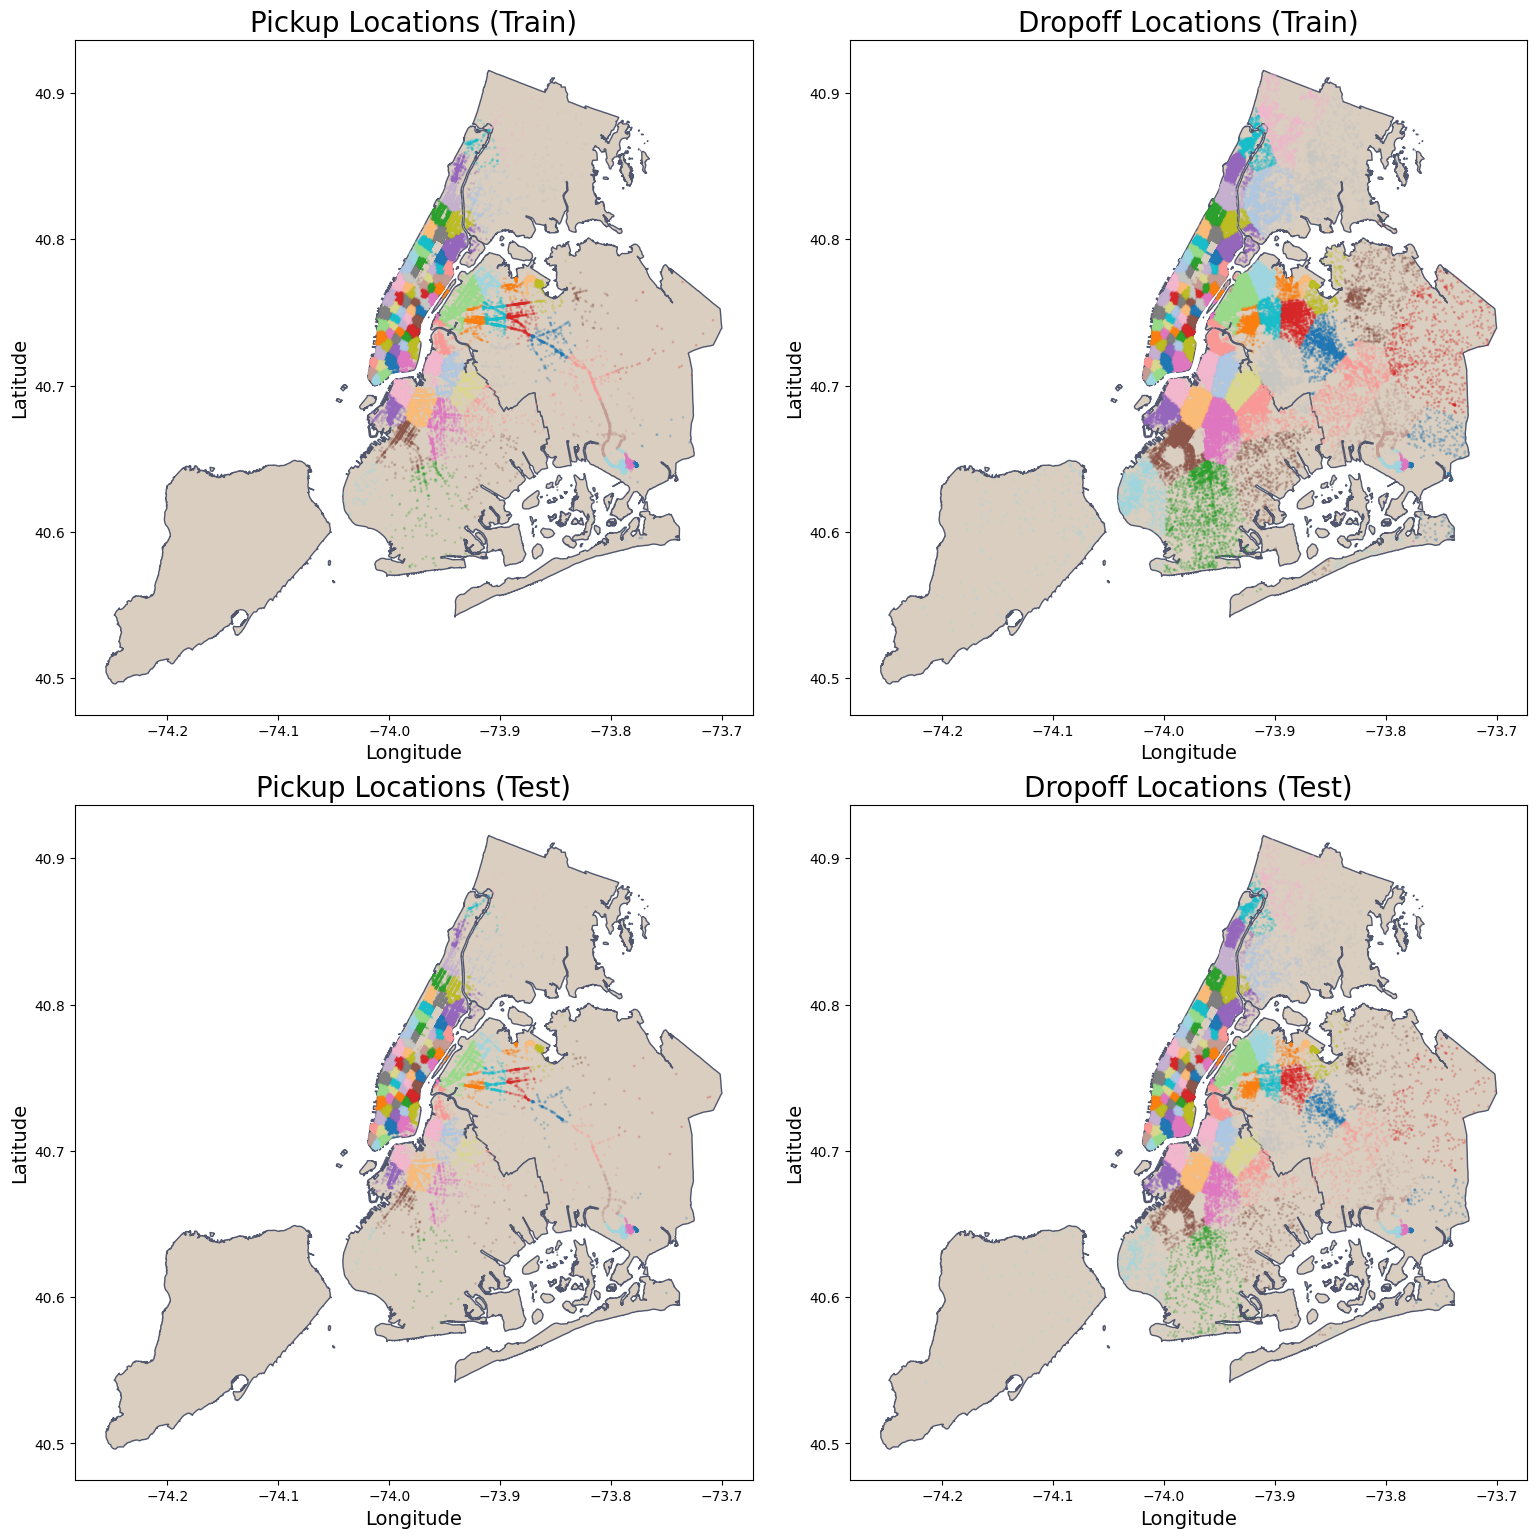

In [221]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Titles and Column names
titles = ['Pickup Locations', 'Dropoff Locations']
# Column names 
location_columns = [('pickup_latitude', 'pickup_longitude', 'pickup_cluster'), 
                    ('dropoff_latitude', 'dropoff_longitude', 'dropoff_cluster')]

# Loop for training data
for ax, title, (lat_col, lon_col, cluster_col) in zip(axes[:2], titles, location_columns):
    plot_clusters_map(  df_train, nyc_boundary, lat_col, lon_col, cluster_col, ax, 
                        title=title + ' (Train)', edgecolor=grey)

# Loop for test data
for ax, title, (lat_col, lon_col, cluster_col) in zip(axes[2:], titles, location_columns):
    plot_clusters_map(  df_test, nyc_boundary, lat_col, lon_col, cluster_col, ax, 
                        title=title + ' (Test)', edgecolor= grey)

plt.tight_layout()  
plt.subplots_adjust(left=0.10, right=0.90, top=0.95, bottom=0.05)
plt.show()

# **5. Exploratory Data Analysis (EDA)**

In a power law, one quantity varies as a power of another. For the dataset, this means that the trip duration varies as a power of the geodesic distance.

The power law relationship would be expressed mathematically as:

Trip Duration=k×(Geodesic Distance)βTrip Duration=k×(Geodesic Distance)β

where:

    ββ is the exponent (in your case, approximately 0.542),
    kk is a constant coefficient,
    Trip Duration is the variable we're predicting, and
    Geodesic Distance is the independent variable.

In this context, ββ indicates that the trip duration increases at a diminishing rate as the geodesic distance increases. This is characteristic of a sub-linear power law relationship, where the exponent (the slope in the log-log plot) is between 0 and 1.

For every proportional increase in distance, the increase in duration is less than proportional. If ββ had been greater than 1, it would imply that duration increases at an accelerating rate relative to distance, which would be a super-linear power law relationship.

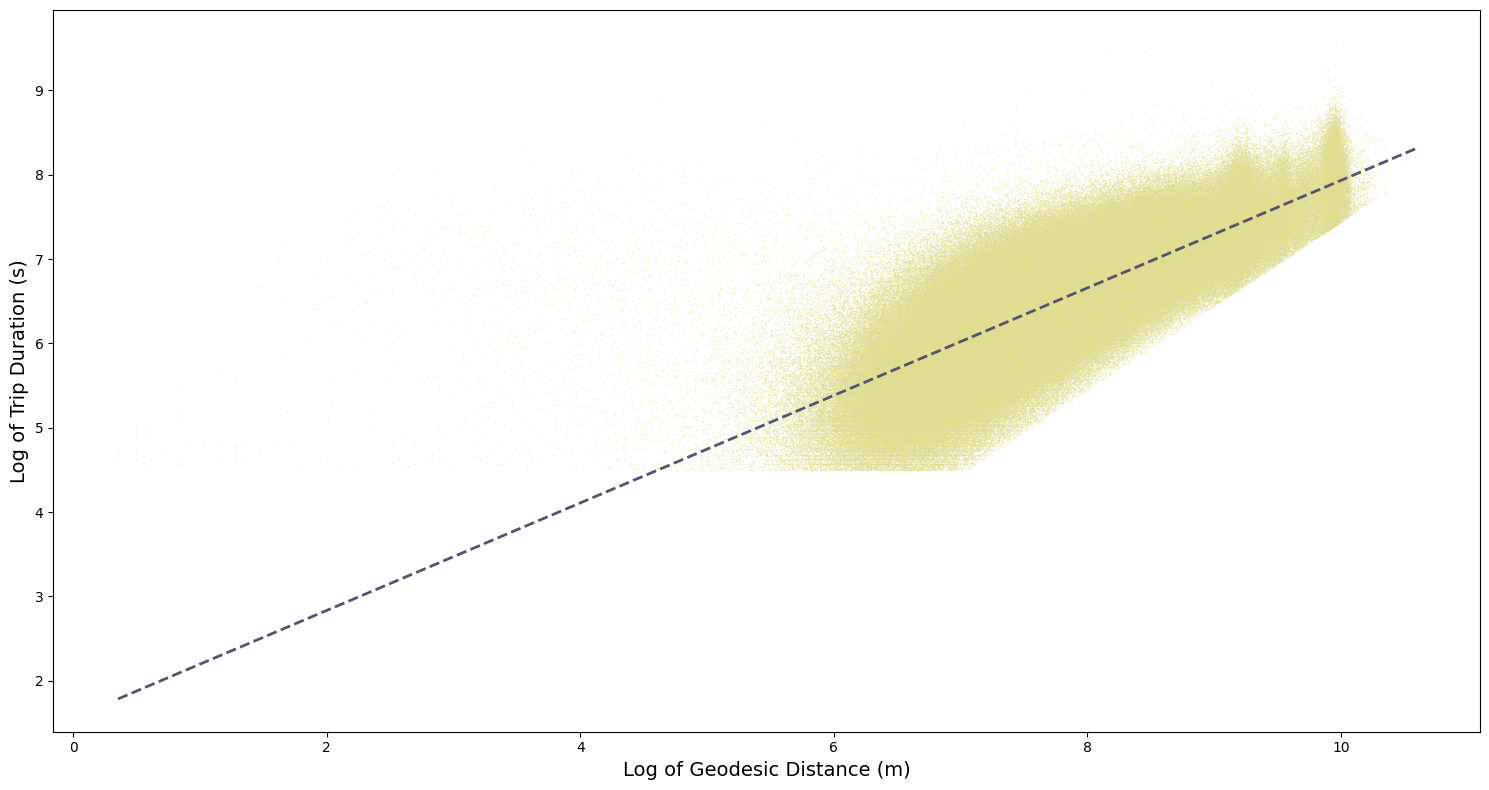

In [ ]:
log_geodesic_distance = np.log1p(taxi_trip['geodesic_distance'])
log_trip_duration = np.log1p(taxi_trip['trip_duration'])

slope, intercept, r_value, p_value, std_err = stats.linregress(log_geodesic_distance, log_trip_duration)


fig, axes = plt.subplots(1, 1, figsize=(15, 8))
#sns.scatterplot(x = np.log1p(trip_outliers['geodesic_distance']),
                #y = np.log1p(trip_outliers['trip_duration']))

sns.scatterplot(x=log_geodesic_distance, 
                y=log_trip_duration , color = yellow,
                marker = 'o', s= 1, alpha=0.3)

# Plot the regression line
x = np.array([min(log_geodesic_distance), max(log_geodesic_distance)])
plt.plot(x, slope * x + intercept, color=grey, linestyle='--', lw=2)

axes.set_xlabel('Log of Geodesic Distance (m)', fontsize=14)
axes.set_ylabel('Log of Trip Duration (s)', fontsize=14)

# Set both the x-axis and y-axis to logarithmic scale
plt.tight_layout()
plt.show()